In [1]:
import numpy as np 
import pandas as pd 
import nltk
import string as s
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import time  
torch.manual_seed(8)

In [2]:
#加载AG-News数据集
train_data = pd.read_csv(r'E:\Jupyter\se3_o_machine\ag-news-classification-dataset\train.csv'
                        ,header=0,names=['classid','title','desc'])
test_data = pd.read_csv(r'E:\Jupyter\se3_o_machine\ag-news-classification-dataset\test.csv'
                       ,header=0,names=['classid','title','desc'])

train_data.head()
test_data.head()

classid                                              title  \
0        3                  Fears for T N pension after talks   
1        4  The Race is On: Second Private Team Sets Launc...   
2        4      Ky. Company Wins Grant to Study Peptides (AP)   
3        4      Prediction Unit Helps Forecast Wildfires (AP)   
4        4        Calif. Aims to Limit Farm-Related Smog (AP)   

                                                desc  
0  Unions representing workers at Turner   Newall...  
1  SPACE.com - TORONTO, Canada -- A second\team o...  
2  AP - A company founded by a chemistry research...  
3  AP - It's barely dawn when Mike Fitzpatrick st...  
4  AP - Southern California's smog-fighting agenc...

In [3]:
train_x=train_data.desc[:60000]
test_x=test_data.desc
train_y=train_data.classid[:60000]
test_y=test_data.classid

df=train_data[:60000]
world = df.desc[df.classid[df.classid==1].index]
sports = df.desc[df.classid[df.classid==2].index]
biz = df.desc[df.classid[df.classid==3].index]
sci = df.desc[df.classid[df.classid==4].index]



#### World News

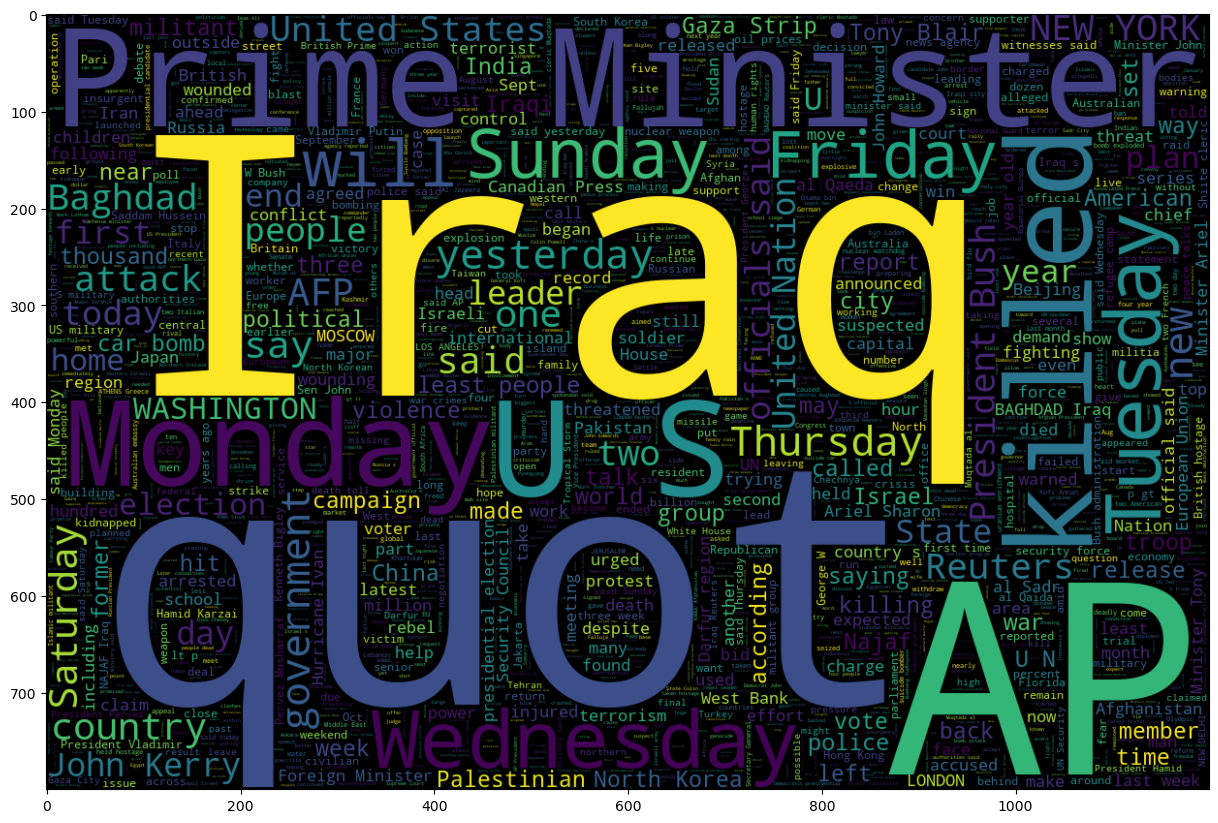

In [4]:
plt.figure(figsize = (15,20)) 
wordcloud = WordCloud(
    min_font_size=3, #最小显示的文字大小
    max_words=2500, #最多显示 2500 个词汇
    width=1200, #像素
    height=800
).generate(" ".join(world))  # 确保 'world' 是一个字符串列表
# 显示词云
plt.imshow(wordcloud,interpolation = 'bilinear')

#### Sports News

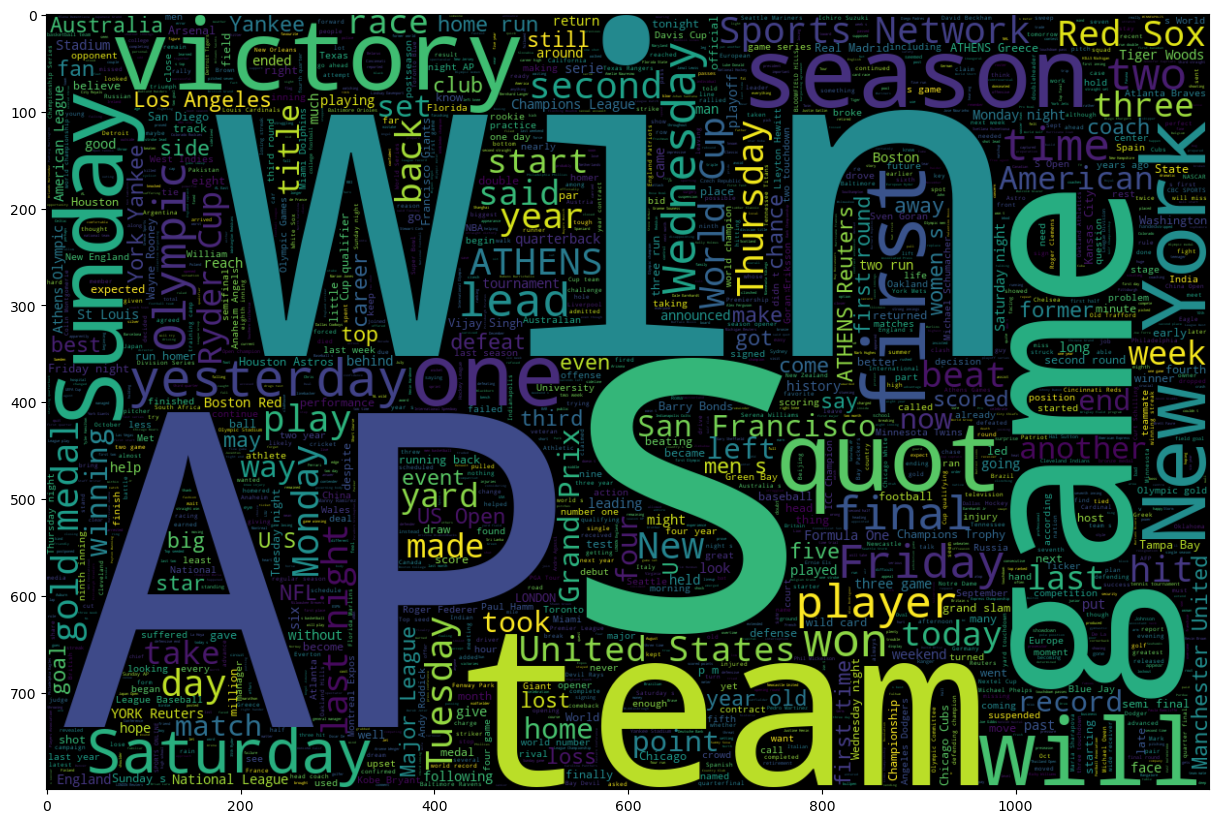

In [5]:
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(
    min_font_size=3, 
    max_words=2500, 
    width=1200, 
    height=800
).generate(" ".join(sports))
plt.imshow(wordcloud,interpolation = 'bilinear');

#### Business News

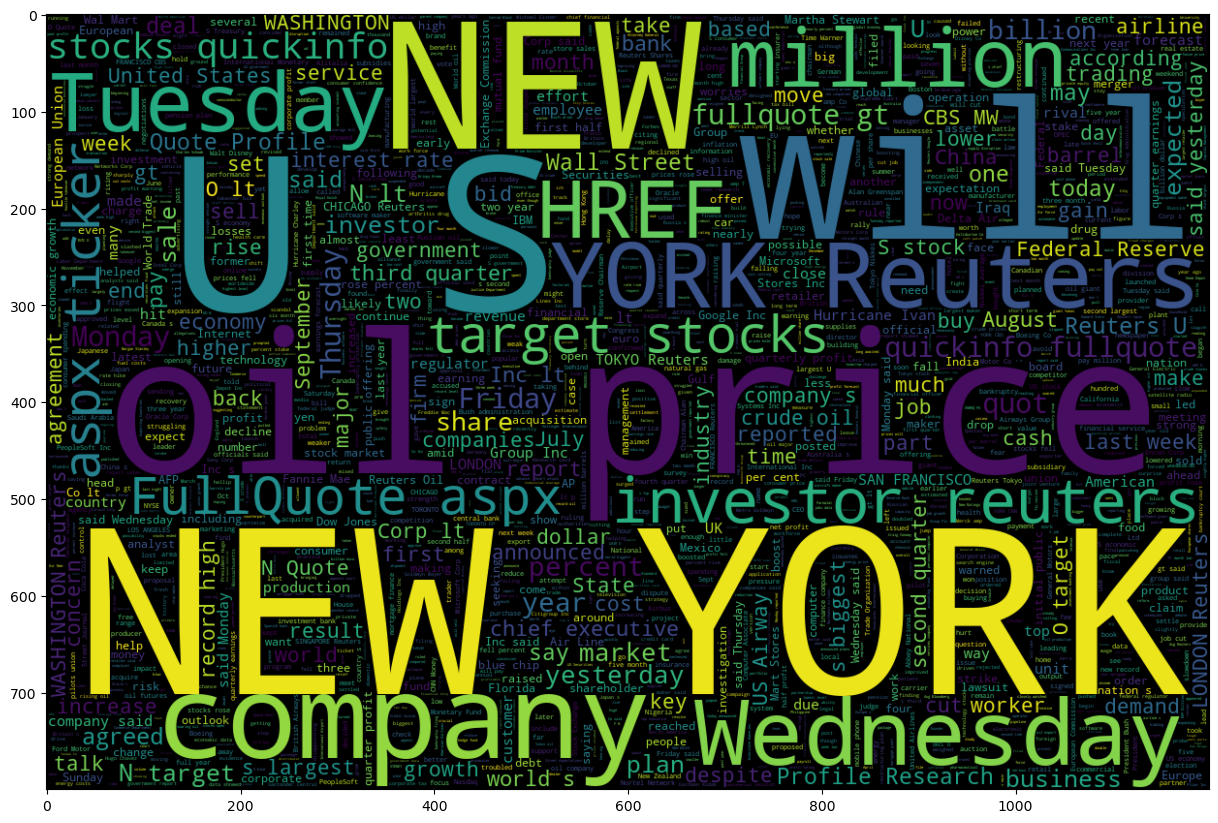

In [6]:
biz = df.desc[df.classid[df.classid==3].index]

plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(
    min_font_size=3, 
    max_words=2500, 
    width=1200, 
    height=800
).generate(" ".join(biz))
plt.imshow(wordcloud,interpolation = 'bilinear');

#### Science and Technology News

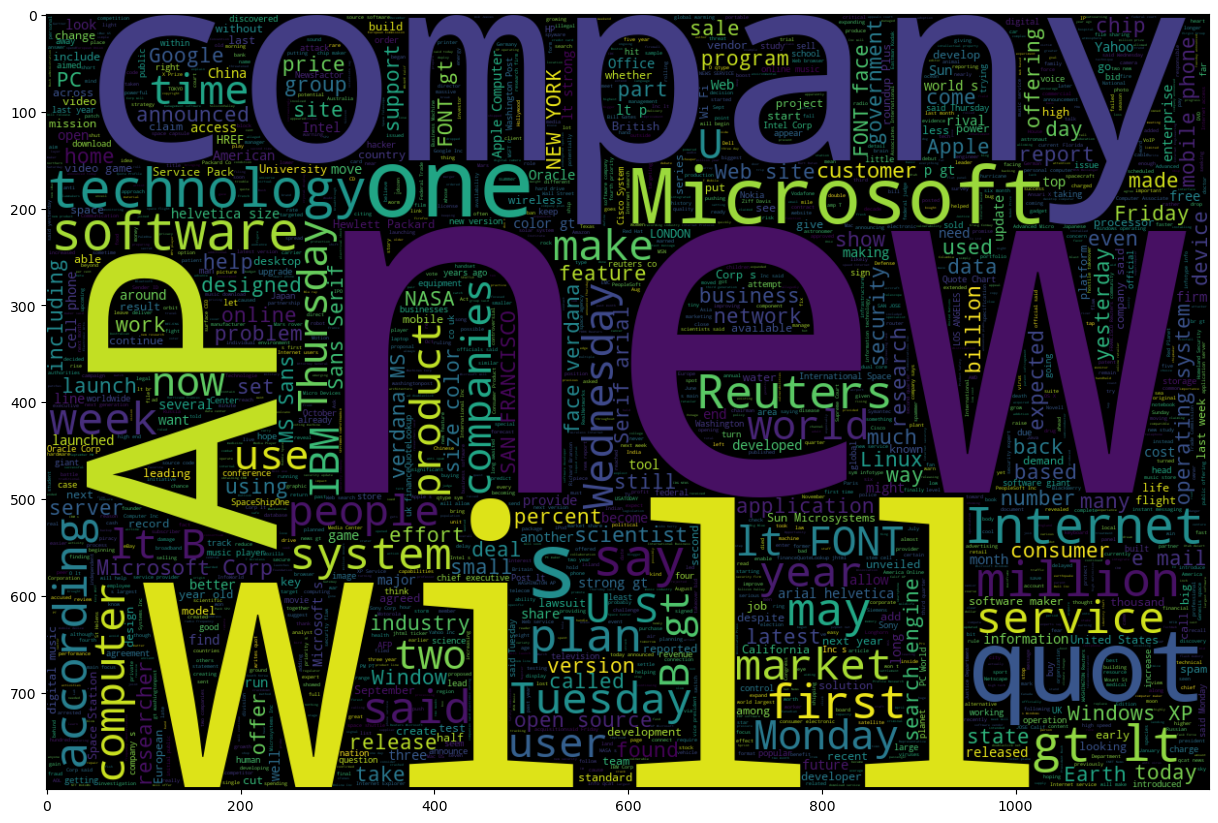

In [7]:
sci = df.desc[df.classid[df.classid==4].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(
    min_font_size=3, 
    max_words=2500, 
    width=1200, 
    height=800
).generate(" ".join(sci))
plt.imshow(wordcloud,interpolation = 'bilinear');

### Feature Extraction

In [4]:
# TF-IDF 是一种常见的文本特征表示方法，用于将文本数据转化为 TF-IDF 矩阵
# 它衡量一个词语在某个文档中的重要性
#(频数; 逆文档频率:用于降低在所有文档中都频繁出现的词的权重)
tfidf = TfidfVectorizer(
    lowercase=True,  # 自动转小写
    stop_words='english',  # 自动移除停用词 "the", "and", "is", "in" 对文本分析没有帮助
    max_features=10000, #选择最常见的 10,000 个单词来表示文本数据
    min_df=6 #词语必须至少出现在 6 个文档中才能被认为是特征
)
 
train_1 = tfidf.fit_transform(train_x) #fit_transform() 会计算 TF-IDF 权重并应用于训练数据，得到一个稀疏矩阵
test_1 = tfidf.transform(test_x)
train_1
train_arr=train_1.toarray() #将稀疏矩阵转换为 NumPy 数组
test_arr=test_1.toarray()

### CNN

In [5]:
from sklearn.preprocessing import LabelEncoder

# 将标签数据转换为整数
train_y_tensor = torch.tensor(train_y - 1).long()  # PyTorch的标签从0开始
test_y_tensor = torch.tensor(test_y - 1).long() #64 位整数类型int64

# 转换为 PyTorch 张量
train_x_tensor = torch.tensor(train_arr).float()  # 特征数据类型为float 浮点数
test_x_tensor = torch.tensor(test_arr).float()

# 创建 TensorDataset
train_dataset = TensorDataset(train_x_tensor, train_y_tensor) #将特征和标签封装成一个数据集对象
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

class CNNTextClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNTextClassifier, self).__init__()
        
        # 卷积层：输入是一个长度为 input_dim 的词向量，输出 128 个特征
        #假设输入数据的长度是 input_dim，经过卷积层处理后，输出的长度会变短，
        # input_dim − kernel_size + 1 = input_dim−4
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        #通过最大池化层处理后，池化窗口大小为 2，
        #意味着每 2 个元素会被池化成一个元素。所以，池化层会将输入长度减半。这个长度向下取整
        #(input_dim - 4) // 2
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # 全连接层
        self.fc1 = nn.Linear(32 * (input_dim - 4) // 2, 128)  # 根据卷积和池化后的尺寸调整
        self.fc2 = nn.Linear(128, output_dim)  # 输出为4类

    def forward(self, x):
        # 卷积层：输入 x 的维度是 (batch_size, 1, input_dim)
        x = self.conv1(x)  # 卷积层
        x = torch.relu(x)  # 激活函数
        x = self.pool(x)  # 池化层

        # 展平
        x = x.view(x.size(0), -1)

        # 全连接层
        x = self.fc1(x)
        x = torch.relu(x)  # 激活函数
        x = self.fc2(x)
        return x

# 初始化模型
input_dim = train_arr.shape[1]  # 特征维度
output_dim = 4  # 类别数
model = CNNTextClassifier(input_dim, output_dim)

# 打印模型结构
print(model)


CNNTextClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=159936, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


Epoch [1/10], Loss: 1.2943, Accuracy: 0.3881
Epoch [2/10], Loss: 0.8265, Accuracy: 0.5848
Epoch [3/10], Loss: 0.5081, Accuracy: 0.8146
Epoch [4/10], Loss: 0.3747, Accuracy: 0.8775
Epoch [5/10], Loss: 0.3338, Accuracy: 0.8912
Epoch [6/10], Loss: 0.2843, Accuracy: 0.9065
Epoch [7/10], Loss: 0.2461, Accuracy: 0.9160
Epoch [8/10], Loss: 0.2187, Accuracy: 0.9255
Epoch [9/10], Loss: 0.1948, Accuracy: 0.9333
Epoch [10/10], Loss: 0.1738, Accuracy: 0.9408
Training time for CNN: 2137.5934 seconds


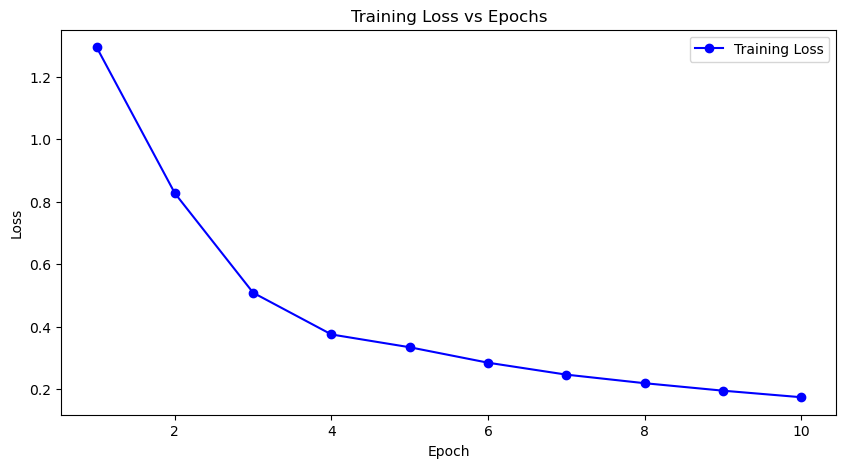

In [7]:
# 损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 分类任务
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
# 训练模型
train_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # 添加一个额外的维度 (batch_size, 1, input_dim) 作为 Conv1d 的输入格式
        inputs = inputs.unsqueeze(1)  # 增加一个维度：从 (batch_size, input_dim) 变成 (batch_size, 1, input_dim)
        
        # 前向传播
        outputs = model(inputs)
        
        # 计算损失
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()  # 清空之前的梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        # 计算正确分类的数量
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()
    avg_loss = running_loss/len(train_loader)
    train_losses.append(avg_loss)
    accuracy = correct / total  # 准确率    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

CNN_train_time = time.time() - start_time
print(f"Training time for CNN: {CNN_train_time:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()

In [8]:
model.eval()  # 切换到评估模式

test_y_true = []  # 真实标签
test_y_pred = []  # 预测标签

# 在测试集上评估
with torch.no_grad():  # 禁用梯度计算，提高效率
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # 增加一个维度 (batch_size, 1, input_dim)
        
        # 前向传播
        outputs = model(inputs)
        
        # 获取预测结果
        _, predicted = torch.max(outputs, 1)
        
        # 记录真实标签和预测标签
        test_y_true.extend(labels.numpy())
        test_y_pred.extend(predicted.numpy())

# 计算准确率
accuracy = accuracy_score(test_y_true, test_y_pred)
print(f'Accuracy on CNN test set: {accuracy:.4f}')

# 输出分类报告（包括精度、召回率、F1分数等）
report = classification_report(test_y_true, test_y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)
# 计算 R²，虽然这个指标在分类任务中不常用
test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred)

# 计算 TSS (总平方和) 和 RSS (残差平方和)
TSS = np.sum((test_y_true - np.mean(test_y_true))**2)
RSS = np.sum((test_y_true - test_y_pred)**2)

# 计算 R²
R_squared = 1 - (RSS / TSS)
print(f'R² for classification task: {R_squared:.4f}')

Accuracy on CNN test set: 0.8791
              precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88      1900
     Class 1       0.95      0.95      0.95      1900
     Class 2       0.85      0.82      0.84      1900
     Class 3       0.84      0.87      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

R² for classification task: 0.7033


精度表示所有被模型预测为Class 0的样本中，实际上属于Class 0的比例
召回率表示所有实际属于Class 0的样本中，模型正确预测的比例
F1分数是精度和召回率的调和平均数，它综合考虑了精度和召回率。
支持度表示在测试集里，Class 0有1900个样本。

### RNN

Epoch [1/10], Loss: 0.6034, Accuracy: 0.8422
Epoch [2/10], Loss: 0.2696, Accuracy: 0.9128
Epoch [3/10], Loss: 0.2169, Accuracy: 0.9278
Epoch [4/10], Loss: 0.1855, Accuracy: 0.9372
Epoch [5/10], Loss: 0.1631, Accuracy: 0.9447
Epoch [6/10], Loss: 0.1460, Accuracy: 0.9503
Epoch [7/10], Loss: 0.1318, Accuracy: 0.9550
Epoch [8/10], Loss: 0.1204, Accuracy: 0.9591
Epoch [9/10], Loss: 0.1103, Accuracy: 0.9636
Epoch [10/10], Loss: 0.1022, Accuracy: 0.9658
Training time for RNN: 69.1735 seconds


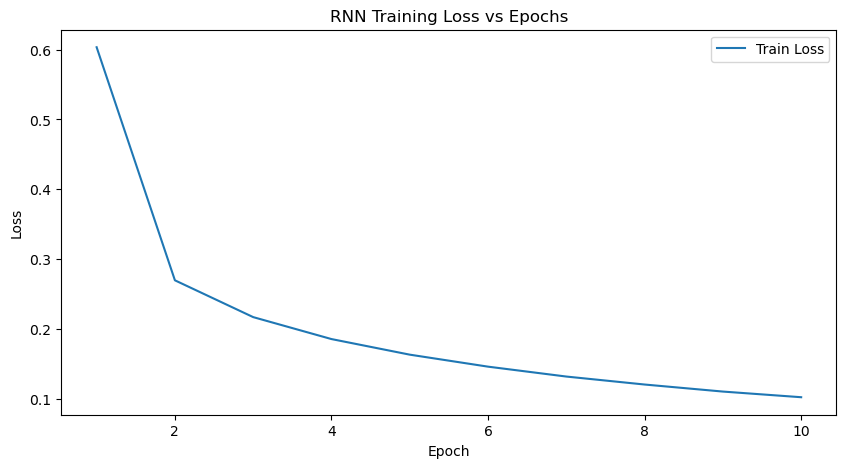

In [9]:

# 数据加载 (train_arr是tfidf转换后的特征矩阵 train_y和test_y是类别标签 
# train_dataset = TensorDataset(torch.tensor(train_arr, dtype=torch.float32), torch.tensor(train_y.values - 1, dtype=torch.long))
# test_dataset = TensorDataset(torch.tensor(test_arr, dtype=torch.float32), torch.tensor(test_y.values - 1, dtype=torch.long))
# #每次加载64个样本 打乱顺序
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64)
 
# 定义 RNN 模型
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): #特征数，4个类别
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
 
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)  # 初始化隐藏状态
        out, _ = self.rnn(x.unsqueeze(1), h0)  # 增加时间步维度
        return self.fc(out[:, -1, :])
 
# 模型参数
input_dim = train_arr.shape[1] #10000列
hidden_dim = 64
output_dim = 4  # 分类数
 
# 初始化模型
model_rnn = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
start_time = time.time() 
# 训练 RNN
train_losses = []
num_epochs =10
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    model_rnn.train()
    for batch_x, batch_y in train_loader: #(batch_size,1000),(batch_size,)
        optimizer.zero_grad()
        outputs = model_rnn(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # 累加当前批次损失
         # 计算预测准确率
        _, predicted = torch.max(outputs, 1)  # 获取预测的类别
        correct += (predicted == batch_y).sum().item()  # 计算预测正确的数量
        total += batch_y.size(0)  # 总样本数
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    accuracy = correct / total  # 准确率
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

RNN_train_time = time.time() - start_time
print(f"Training time for RNN: {RNN_train_time:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN Training Loss vs Epochs")
plt.legend()
plt.show()


In [10]:
model_rnn.eval()  # 设置模型为评估模式
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:  # 假设您已经有了test_loader
        outputs = model_rnn(batch_x)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 计算准确率
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on RNN test set: {accuracy:.4f}')

report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)
# 计算 R²
# y_true = torch.tensor(y_true)
# y_pred = torch.tensor(y_pred)

# # 计算R²值

from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"Test R^2: {r2:.4f}")


Accuracy on RNN test set: 0.8572
              precision    recall  f1-score   support

     Class 0       0.84      0.87      0.86      1900
     Class 1       0.95      0.92      0.93      1900
     Class 2       0.83      0.80      0.81      1900
     Class 3       0.81      0.84      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Test R^2: 0.6471


### Transformer(BERT)

In [11]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset
import time
from sklearn.metrics import r2_score
# 读取数据
train_data = pd.read_csv(r'E:\Jupyter\se3_o_machine\ag-news-classification-dataset\train.csv', header=0, names=['classid', 'title', 'desc'])
test_data = pd.read_csv(r'E:\Jupyter\se3_o_machine\ag-news-classification-dataset\test.csv', header=0, names=['classid', 'title', 'desc'])

train_x = train_data.desc[:60000]
test_x = test_data.desc
train_y = train_data.classid[:60000]
test_y = test_data.classid

# 使用BERT的tokenizer对文本进行编码
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
#使用了bert-base-uncased预训练模型的Tokenizer，它会将文本转化为BERT要求的格式，
#例如分词、添加特殊符号（如[CLS]和[SEP]）、填充和截断。

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len #最大文本长度

    def __len__(self):
        return len(self.texts) #返回数据集的大小（文本数量）

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus( #将文本编码为 BERT 模型需要的输入形式
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#  设置 BERT 输入的最大长度为 20个词。
#如果文本长度超过这个限制，会被截断，如果不足，会进行填充（padding）。
MAX_LEN = 20

# 创建训练和测试数据集
train_dataset = NewsDataset(train_x, train_y.values - 1, tokenizer, MAX_LEN)
test_dataset = NewsDataset(test_x, test_y.values - 1, tokenizer, MAX_LEN)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 定义BERT模型
class BertClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
    
    def forward(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask)

# 初始化模型
model = BertClassifier(num_labels=4)

# 将模型移到GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 使用AdamW优化器和交叉熵损失函数
optimizer = AdamW(model.parameters(), lr=0.001)
#是专为 BERT 等大模型设计的优化器，能够处理权重衰减
criterion = torch.nn.CrossEntropyLoss()
#适用于多分类任务

# import torch
# print(torch.cuda.is_available())


D:\Miniconda3\envs\amikey_38\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
D:\Miniconda3\envs\amikey_38\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this 

Epoch 1/10, Loss: 1.3970, Accuracy: 0.2552
Epoch 2/10, Loss: 1.3879, Accuracy: 0.2536
Epoch 3/10, Loss: 1.3878, Accuracy: 0.2537
Epoch 4/10, Loss: 1.3868, Accuracy: 0.2560
Epoch 5/10, Loss: 1.3867, Accuracy: 0.2560
Epoch 6/10, Loss: 1.3867, Accuracy: 0.2572
Epoch 7/10, Loss: 1.3868, Accuracy: 0.2556
Epoch 8/10, Loss: 1.3869, Accuracy: 0.2522
Epoch 9/10, Loss: 1.3870, Accuracy: 0.2574
Epoch 10/10, Loss: 1.3869, Accuracy: 0.2559
Training time for BERT: 1437.5669 seconds


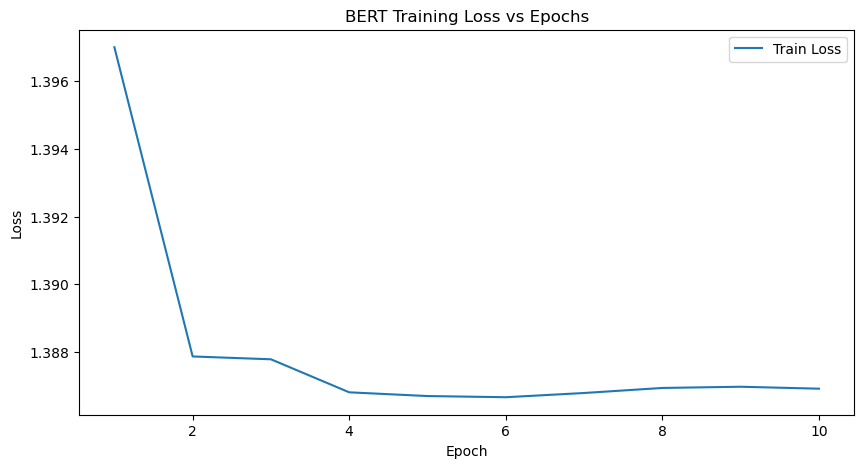

In [12]:
start_time = time.time() 
# 训练 RNN
train_losses = []
# 训练BERT模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 前向传播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # 计算损失
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # 计算准确率
        _, preds = torch.max(logits, dim=1)
        #沿着每个样本的类别维度（通常是维度 1）找到最大值的索引，也就是模型预测的类别。
        correct_preds += torch.sum(preds == labels)
        #计算当前 batch 中预测正确的样本数量
        total_preds += labels.size(0)
        #当前 batch 中的样本数量
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    accuracy = correct_preds.double() / total_preds
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

BERT_train_time = time.time() - start_time
print(f"Training time for BERT: {BERT_train_time:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT Training Loss vs Epochs")
plt.legend()
plt.show()


In [13]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Don't compute gradients during evaluation
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted class labels
        _, preds = torch.max(logits, dim=1)  # Get the index of the max logit (predicted class)

        # Append predictions and labels
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

from sklearn.metrics import classification_report, accuracy_score

# Print classification report
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

# Now calculate accuracy and other classification metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on BERT test set: {accuracy:.4f}')
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R^2 for regression
r2 = r2_score(all_labels, all_preds)
print(f"BERT Test R^2: {r2:.4f}")


              precision    recall  f1-score   support

     Class 0       0.25      1.00      0.40      1900
     Class 1       0.00      0.00      0.00      1900
     Class 2       0.00      0.00      0.00      1900
     Class 3       0.00      0.00      0.00      1900

    accuracy                           0.25      7600
   macro avg       0.06      0.25      0.10      7600
weighted avg       0.06      0.25      0.10      7600

Accuracy on BERT test set: 0.2500
BERT Test R^2: -1.8000


D:\Miniconda3\envs\amikey_38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Miniconda3\envs\amikey_38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Miniconda3\envs\amikey_38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### conclusion

Training time for CNN: 2137.5934 seconds = 36 min /
Accuracy on CNN test set: 0.8791
    
Training time for RNN: 69.1735 seconds = 1 min  /
Accuracy on RNN test set: 0.8572
    
Training time for BERT: 1437.5669 seconds = 24 min /
Accuracy on BERT test set: 0.2500 

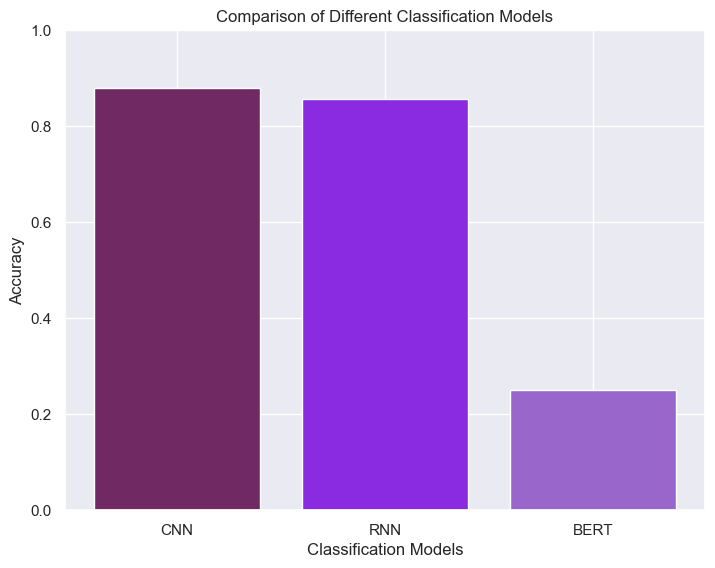

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set()

# Create a figure and axis
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# Model names and accuracy data
Models = ['CNN', 'RNN', 'BERT']
Accuracy = [0.8791, 0.8572, 0.2500]

# Create the bar plot with different colors for each bar
ax.bar(Models, Accuracy, color=['#702963', '#8a2be2', '#9966cc'])

# Set the title and labels for the axes
ax.set_title('Comparison of Different Classification Models')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classification Models')

# Set the Y-axis limits (0 to 1, since accuracy is between 0 and 1)
ax.set_ylim(0, 1)

# Show the plot
plt.show()
